# Exercise 3 | TKO_7092 Evaluation of Machine Learning Methods 2024
## deadline: 14.2.2024 - 23:59

Regarding any questions about this exercise, please contact course assistant Jonne Pohjankukka (jjepoh@utu.fi)

********************************************

Student name: Arvin Jalali

Student number: 2310744

Student email: arvin.a.jalali@utu.fi

********************************************

## Water permeability prediction in forestry <br>

In this task, the client wants you to estimate the spatial prediction performance of K-nearest neighbor regression model with K=15 (15NN), using spatial leave-one-out cross-validation (i.e. SKCV, with number of folds == number of data points). The client wants you to use the C-index as the performance measure.  

In other words, the client wants you to answer the question: "What happens to the prediction performance of water permeability using 15-nearest neighbor regression model, when the geographical distance between known data and unknown data increases?".

In this task, you have three data files available (with 1691 data points): 

- input.csv, contains the 75 predictor features. 
- output.csv, contains the water permebility values. 
- coordinates.csv, contains the corresponding geographical coordinate locations of the data points. The unit of the coordinates is metre, and you can use Euclidean distance to calculate distances between the coordinate points. 

Implement the following tasks to complete this exercise:

********************************************

#### 1. Z-score standardize the predictor features (input.csv). 

#### 2. Perform spatial leave-one-out cross-validation with 15NN model for the provided data set (refer to the lectures 3.1.3 and 3.1.4 for help). Estimate the water permeability prediction performance (using 15NN model and C-index) with the following distance parameter values: d = 0, 10, 20, ..., 250 (that is, 10 meter intervals from 0m to 250m). 

#### 3. When you have calculated the C-index performance measure for each value of d, visualize the results with the C-index (y-axis) as a function of d (x-axis).

********************************************

Your .ipynb-file must include the following: 

- Your own implementation of the spatial leave-one-out cross-validation for the current task. You can use third-party libraries (e.g. Scikit-learn) if you want for implementing e.g. the 15-nearest neighbor. Also, try to follow good programming practices and add comments to relevant parts of your code explaining what you are doing and why.


- Plot of the graph C-index vs. distance parameter value. 


<br><br><br>
-- START IMPLEMENTING YOUR EXERCISE AFTER THIS LINE --
<br><br><br>

### Import necessary libraries

In [5]:
# In this cell, import all the libraries that you need. For example: 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

### Read in the datasets

In [6]:
# In this cell, read the files input.csv, output.csv and coordinates.csv.
# Print out the dataset dimesions (i.e. number of rows and columns).

input_data = pd.read_csv("input.csv", header=None)
output_data = pd.read_csv("output.csv", header=None)
coordinates_data = pd.read_csv("coordinates.csv", header=None)

input_array = input_data.to_numpy()
output_array = output_data.to_numpy()
coordinates_array = coordinates_data.to_numpy()

print("Dimensions of input.csv:", input_data.shape)
print("Dimensions of output.csv:", output_data.shape)
print("Dimensions of coordinates.csv:", coordinates_data.shape)

Dimensions of input.csv: (1691, 75)
Dimensions of output.csv: (1691, 1)
Dimensions of coordinates.csv: (1691, 2)


### Standardization of the predictor features (input.csv)

In [7]:
# Standardize the predictor features (input.csv) by removing the mean and scaling to unit variance. 
# In other words, z-score the predictor features. You are allowed to use third-party libraries for doing this. 

scaler = StandardScaler()
input_data_standardized = scaler.fit_transform(input_data)
input_data_standardized = pd.DataFrame(input_data_standardized)

input_data_standardized_array = input_data_standardized.to_numpy()

### Functions and analysis code

In [8]:
# Include here all the functions and other relevant code that you need in order to implement the task.

# Note! Utilize the following two functions in your implementation:

### Function for calculating C-index ###
# y: array containing true label values.
# yp: array containing the predicted label values.
def cindex(y, yp):
    n = 0
    h_num = 0 
    for i in range(0, len(y)):
        t = y[i]
        p = yp[i]
        for j in range(i+1, len(y)):
            nt = y[j]
            np = yp[j]
            if (t != nt): 
                n = n + 1
                if (p < np and t < nt) or (p > np and t > nt): 
                    h_num += 1
                elif (p == np):
                    h_num += 0.5
    return h_num/n


### Function for calculating the pairwise spatial distances between the data points ###
# The function will return a n-by-n matrix of Euclidean distances. For example, the
# distance_matrix element at indices i,j will contain the spatial distance between 
# data point i and j. Note that the element value is 0 always when i==j.
# coordinate_array: n-by-2 array containing the coordinates of the exercise data points.
def cdists(coordinate_array):
    number_of_observations = coordinate_array.shape[0]
    distance_matrix = np.zeros((number_of_observations, number_of_observations))
    for i in range(0, number_of_observations):
        distance_matrix[i, :] = np.sqrt(np.sum((coordinate_array - coordinate_array[i])**2, axis=1))
    return distance_matrix


### Results for spatial leave-one-out cross-validation with 15-nearest neighbor regression model

In [9]:
# In this cell, run your script for the Spatial leave-One-Out cross-validation 
# with 15-nearest neighbor regression model and visualize the results as 
# requested in the task assignment.

distance_matrix = cdists(coordinates_array)

def leave_one_out_cv_knn(input_data, output_data, nearby_distance):
    n_samples, n_features = input_data.shape
    cv_scores = []
    y_pred_list = []

    for test_index in range(n_samples):
        test_point = input_data[test_index]
        distances_to_interest = distance_matrix[test_index, :]
        nearby_points = np.where(distances_to_interest < nearby_distance)[0]
        #nearby_points = nearby_points[nearby_points != test_index]
        remove_indices = nearby_points.tolist()
        remove_indices.append(test_index)
        train_indices = np.setdiff1d(np.arange(n_samples), remove_indices)
        X_train = input_data[train_indices]
        y_train = output_data[train_indices]

        # fitting the KNN model
        knn = NearestNeighbors(n_neighbors=15)
        knn.fit(X_train)

        # finding k-nearest neighbors for the test point
        distances, indices = knn.kneighbors([test_point])

        # calculating the prediction
        y_pred = np.mean(y_train[indices])
        y_pred_list.append(y_pred)

    # calculating c-index for all predictions here outside the cross validation loop
    cv_score = cindex(output_data, np.array(y_pred_list))
    return cv_score


c_index_list = []
# looping over the range of nearby distances to call the cross validation function
for nearby_distance in range(0, 251, 10):
    return_value = leave_one_out_cv_knn(input_array, output_array, nearby_distance)
    c_index_list.append(return_value)
print(c_index_list)

[0.7208730150952852, 0.7177592537892203, 0.7139584841158626, 0.7128466014959494, 0.709170424272289, 0.7070054554693985, 0.7012710529741898, 0.6957557372023255, 0.6889227512812723, 0.6847534539406912, 0.6803111731429076, 0.6348076306575822, 0.6034911784345869, 0.5903305759670964, 0.5873760550110664, 0.5843098908206162, 0.5839347135563585, 0.583271503746873, 0.5830695659843014, 0.5818474400451332, 0.5809472945939476, 0.5789289669046056, 0.5780414206899062, 0.5776959916229076, 0.577106277359592, 0.5766604043794946]


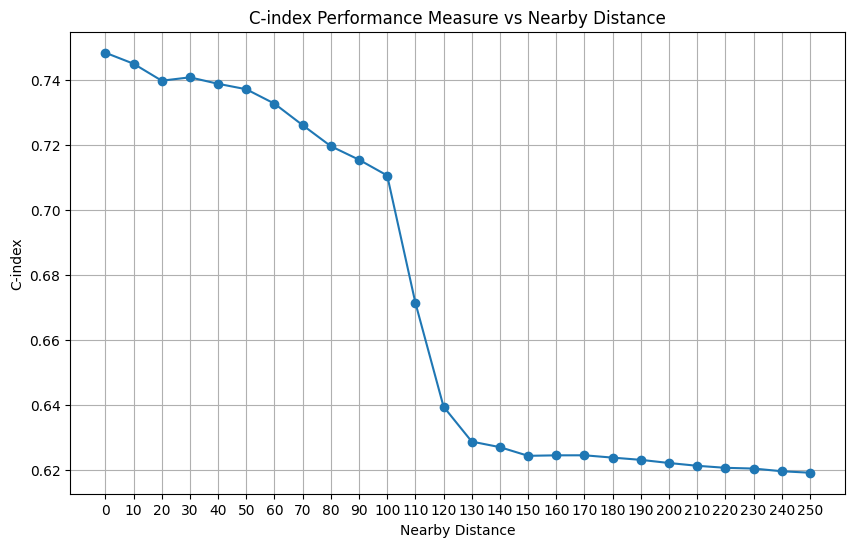

In [14]:
# Plotting
nearby_distances = range(0, 251, 10)
plt.figure(figsize=(10, 6))
plt.plot(nearby_distances, c_index_list, marker='o', linestyle='-')
plt.title('C-index Performance Measure vs Nearby Distance')
plt.xlabel('Nearby Distance')
plt.ylabel('C-index')
plt.grid(True)
plt.xticks(range(0, 251, 10))
plt.show()

### Interpretation of the results

# In this cell, give a brief commentary on the results, what happens to the prediction performance as the prediction distance increases?.
 As we can see from the illustration, by increasing the distance, the performance metric C-index values decreases. The reason is that, in spatial cross validation, by removing the nearby data points from training data, we avoid from optimistic results and it leads to more reliable cross validation. On the other hand, as much as we increase the hyperparameter distance, more nearby data points will be targeted to remove from traing data. So, it is logical that by increasing the distance, performnce metric C_index will be decrease which is much more reliable. In coclusion, prediction performance will be more robust and reliable by prediction distance increases.